In [382]:
import requests
from dataclasses import dataclass
import json
import itertools
import numpy as np
from statistics import NormalDist

%load_ext autoreload
%autoreload 2

from league import ESPNLeague
from classes import Stat, Schedule, Matchup, Week, Player

espn_league = ESPNLeague()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [356]:
type(1614211200000)

int

In [357]:
from constants import team_dict

In [358]:
from collections import OrderedDict

In [359]:
def top_200_by_minutes():
    all_players = espn_api.players
    player_mins = {}
    for player in list(all_players.keys()):
        has_played = all_players[player].stats.s21
        if has_played:
            player_mins[player] = has_played.total.minutes
    sorted_player_tuples = sorted(player_mins.items(), key = lambda item: item[1], reverse=True)
    return dict(sorted_player_tuples[:200])

In [360]:
cats = ['points', 'turnovers', 'fgm', 'fga', 'ftm', 'fta', 'made_threes', 
       'rebounds', 'assists', 'steals', 'blocks']

In [361]:
top_200_players = list(top_200_by_minutes().keys())

In [362]:
def get_cat_dists(top_players, all_player_dict, cats, proj_type):    
#     stats = {'avg': {}, 'std': {}}
    stats = {}
    
    cat_lists = {}
    for cat in cats:
        cat_lists[cat] = []
        
    for player in top_players:
        player_avg_stats = getattr(all_player_dict[player].stats, proj_type).avg
        for cat in cats:
            player_cat_stat = getattr(player_avg_stats, cat)
            cat_lists[cat].append(player_cat_stat)
    
    for cat in cats:
        if cat in ('fgm', 'fga', 'fta', 'ftm'):
            continue
        stats[cat] = NormalDist(mu=np.mean(cat_lists[cat]), sigma=np.std(cat_lists[cat]))
    # yeah this is prob bad - using total fgm/fga for mean, vs. list of player fg_pct for std
    # latter seems unnecessarily noisy for mean tho?
    fgms, fgas = np.array(cat_lists['fgm']), np.array(cat_lists['fga'])
    ftms, ftas = np.array(cat_lists['ftm']), np.array(cat_lists['fta'])
    
    fg_pct_mean = np.mean(fgms) / np.mean(fgas)
    fg_pct_std = np.std(fgms / fgas)
    ft_pct_mean = np.mean(ftms) / np.mean(ftas)
    ft_pct_std = np.std(ftms / ftas)

    stats['fg_pct'] = NormalDist(mu=fg_pct_mean, sigma=fg_pct_std)
    stats['ft_pct'] = NormalDist(mu=ft_pct_mean, sigma=ft_pct_std)
    
    return stats

In [363]:
cat_dists = get_cat_dists(top_200_players, espn_api.players, cats, 's21')

In [364]:
cats

['points',
 'turnovers',
 'fgm',
 'fga',
 'ftm',
 'fta',
 'made_threes',
 'rebounds',
 'assists',
 'steals',
 'blocks']

In [365]:
a = 1
a*= 2 * 3

In [366]:
a

6

In [417]:
def get_overall_score(players, all_player_dict, cats, proj_type, cat_dists):
    player_probs = {}
    for player in players:
        prob = 1
        stats = getattr(all_player_dict[player].stats,proj_type)
#         print(f"curr player is {player} \n {stats}")
        if stats is None:
            continue  # Player hasn't played enough games to have recorded stats in ESPN data
        player_avg_stats = getattr(all_player_dict[player].stats, proj_type).avg
        player_probs[player] = {}
        for cat in cats:
            if cat in ('fgm', 'fga', 'fta', 'ftm'):
                continue
            cat_stat = getattr(player_avg_stats, cat)
            cat_prob = cat_dists[cat].cdf(cat_stat)
            player_probs[player][cat] = cat_prob
            prob *= cat_prob
    
        
        fgm = getattr(player_avg_stats, 'fgm')
        fga = getattr(player_avg_stats, 'fga')
        ftm = getattr(player_avg_stats, 'ftm')
        fta = getattr(player_avg_stats, 'fta')
        fg_pct = fgm/fga if fga else 0
        ft_pct = ftm/fta if fta else 0
        fg_prob = cat_dists['fg_pct'].cdf(fg_pct)
        ft_prob = cat_dists['ft_pct'].cdf(ft_pct)
        player_probs[player]['fg_pct'] = fg_prob
        player_probs[player]['ft_pct'] = ft_prob
        prob *= (fg_prob*ft_prob)
        
        player_probs[player]['total'] = prob
        
    return player_probs

In [418]:
player_scores = get_overall_score(espn_api.players, espn_api.players, cats, 's21', cat_dists)

In [369]:
import seaborn as sns

/opt/miniconda3/envs/fantasy/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

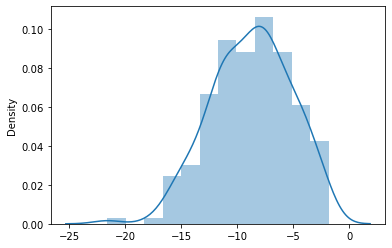

In [370]:
sns.distplot(x=[np.log(score['total']) for score in player_scores.values()])

In [371]:
sorted_player_scores = sorted(player_scores.items(), key=lambda score: -score[1]['total'])

In [372]:
for player in list(score_tuple[0] for score_tuple in sorted_player_scores[:20]):
    print(player)

Kevin Durant
Paul George
Nikola Jokic
James Harden
Kyrie Irving
Bradley Beal
Zach LaVine
Joel Embiid
Jayson Tatum
Kawhi Leonard
Luka Doncic
Jaylen Brown
Tobias Harris
Khris Middleton
Stephen Curry
Nikola Vucevic
Damian Lillard
Brandon Ingram
Gordon Hayward
Anthony Davis


In [375]:
def get_overall_log_score(players, all_player_dict, cats, proj_type, cat_dists):
    player_scores = {}
    for player in players:
        log_score = 0
        player_avg_stats = getattr(all_player_dict[player].stats, proj_type).avg
        player_scores[player] = {}
        for cat in cats:
            if cat in ('fgm', 'fga', 'fta', 'ftm'):
                continue
            cat_stat = getattr(player_avg_stats, cat)
            cat_score = np.log(cat_dists[cat].cdf(cat_stat))
            player_scores[player][cat] = cat_score
            log_score += cat_score
        
        fgm = getattr(player_avg_stats, 'fgm')
        fga = getattr(player_avg_stats, 'fga')
        ftm = getattr(player_avg_stats, 'ftm')
        fta = getattr(player_avg_stats, 'fta')
        fg_score = np.log(cat_dists['fg_pct'].cdf(fgm/fga))
        ft_score = np.log(cat_dists['ft_pct'].cdf(ftm/fta))
        player_scores[player]['fg_pct'] = fg_score
        player_scores[player]['ft_pct'] = ft_score
        log_score += (fg_score+ft_score)
        
        player_scores[player]['total'] = log_score
        
    return player_scores

In [376]:
log_scores = get_overall_log_score(top_200_players, espn_api.players, cats, 's21', cat_dists)

In [473]:
def assign_games(team_no, no_games, rating_dict):
    remaining_games = espn_api.remaining_games
    all_players = espn_api.players
    
    roster = espn_api.teams[team_no].roster
    players = list(roster.keys())
    
    games_played_dict = {}
    for player in players:
        games_played_dict[player] = {}
        games_played_dict[player]['Rating'] = rating_dict[player]
    games_played_dict = dict(sorted(games_played_dict.items(), key = lambda item: item[1]['Rating'], reverse=True))
    
    for player in games_played_dict.keys():
        games_left = remaining_games[all_players[player].nba_tid]
        if no_games >= games_left:
            games_played_dict[player]['Games'] = games_left
            no_games -= games_left
        else:
            games_played_dict[player]['Games'] = no_games
            no_games = 0

    return games_played_dict 

In [389]:
espn_league.user_tid

9

In [475]:
my_players = espn_league.teams[espn_league.user_tid].roster.keys()
my_player_scores = {player: player_scores[player] for player in my_players}
my_player_total_scores = {player: score['total'] for player,score in my_player_scores.items()}
my_assigned_games = assign_games(espn_league.user_tid, 6, my_player_total_scores)

In [476]:
my_assigned_games

{'Nikola Jokic': {'Rating': 0.1148001013359574, 'Games': 0},
 'Alec Burks': {'Rating': 0.022492571525730212, 'Games': 1},
 'Shai Gilgeous-Alexander': {'Rating': 0.011389728822115173, 'Games': 1},
 'Julius Randle': {'Rating': 0.008673700555343599, 'Games': 1},
 'Tyrese Haliburton': {'Rating': 0.0016424956842709668, 'Games': 1},
 'Jimmy Butler': {'Rating': 0.0016210306043101107, 'Games': 0},
 'Chris Paul': {'Rating': 0.0013172475907972914, 'Games': 0},
 'Larry Nance Jr.': {'Rating': 0.00041930785640187455, 'Games': 1},
 'Mason Plumlee': {'Rating': 0.00029078030639863794, 'Games': 0},
 'Robert Williams III': {'Rating': 0.0001062255278211293, 'Games': 1},
 'Kendrick Nunn': {'Rating': 0.00010392624789707614, 'Games': 0},
 'LaMarcus Aldridge': {'Rating': 0.0001010494836627684, 'Games': 0},
 'Kentavious Caldwell-Pope': {'Rating': 9.811310448637596e-05, 'Games': 0},
 'Joe Ingles': {'Rating': 6.973603816258762e-05, 'Games': 0}}

In [468]:
Stat.__dataclass_fields__

{'points': Field(name='points',type=<class 'float'>,default=<dataclasses._MISSING_TYPE object at 0x7fcd2fb21f40>,default_factory=<dataclasses._MISSING_TYPE object at 0x7fcd2fb21f40>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),_field_type=_FIELD),
 'turnovers': Field(name='turnovers',type=<class 'float'>,default=<dataclasses._MISSING_TYPE object at 0x7fcd2fb21f40>,default_factory=<dataclasses._MISSING_TYPE object at 0x7fcd2fb21f40>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),_field_type=_FIELD),
 'minutes': Field(name='minutes',type=<class 'float'>,default=<dataclasses._MISSING_TYPE object at 0x7fcd2fb21f40>,default_factory=<dataclasses._MISSING_TYPE object at 0x7fcd2fb21f40>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),_field_type=_FIELD),
 'games_played': Field(name='games_played',type=<class 'int'>,default=<dataclasses._MISSING_TYPE object at 0x7fcd2fb21f40>,default_factory=<dataclasses._MISSING_TYPE object at 

In [469]:
espn_league.matchup

UserMatchup(matchup_id=30, period_id=5, opp_tid=1, user_stat=Stat(points=376.0, turnovers=51.0, minutes=771.0, games_played=28.0, fgm=143.0, fga=313.0, ftm=66.0, fta=87.0, made_threes=24.0, rebounds=193.0, assists=100.0, steals=23.0, blocks=17.0), opp_stat=Stat(points=331.0, turnovers=41.0, minutes=710.0, games_played=25.0, fgm=127.0, fga=260.0, ftm=49.0, fta=76.0, made_threes=28.0, rebounds=170.0, assists=70.0, steals=28.0, blocks=35.0))

In [437]:
def get_projected_stats(assigned_games, proj_type, cats):
    all_players = espn_api.players
    
    stats = {}
    for cat in cats:
        stats[cat] = 0
        for player in list(assigned_games.keys()):
            stats[cat] += getattr(getattr(all_players[player].stats, proj_type).avg, cat) * assigned_games[player]['Games']
    
    return stats

In [445]:
my_proj_stats = get_projected_stats(my_assigned_games, 'last15', cats)

In [463]:

my_players = espn_league.teams[espn_league.user_tid].roster.keys()
my_player_scores = {player: player_scores[player] for player in my_players}
my_player_total_scores = {player: score['total'] for player,score in my_player_scores.items()}
my_assigned_games = assign_games(espn_league.user_tid, 38, my_player_total_scores)

In [464]:
my_assigned_games

{'Nikola Jokic': {'Rating': 0.1148001013359574, 'Games': 0},
 'Alec Burks': {'Rating': 0.022492571525730212, 'Games': 1},
 'Shai Gilgeous-Alexander': {'Rating': 0.011389728822115173, 'Games': 1},
 'Julius Randle': {'Rating': 0.008673700555343599, 'Games': 1},
 'Tyrese Haliburton': {'Rating': 0.0016424956842709668, 'Games': 1},
 'Jimmy Butler': {'Rating': 0.0016210306043101107, 'Games': 0},
 'Chris Paul': {'Rating': 0.0013172475907972914, 'Games': 0},
 'Larry Nance Jr.': {'Rating': 0.00041930785640187455, 'Games': 1},
 'Mason Plumlee': {'Rating': 0.00029078030639863794, 'Games': 0},
 'Robert Williams III': {'Rating': 0.0001062255278211293, 'Games': 1},
 'Kendrick Nunn': {'Rating': 0.00010392624789707614, 'Games': 0},
 'LaMarcus Aldridge': {'Rating': 0.0001010494836627684, 'Games': 1},
 'Kentavious Caldwell-Pope': {'Rating': 9.811310448637596e-05, 'Games': 0},
 'Joe Ingles': {'Rating': 6.973603816258762e-05, 'Games': 0}}

In [443]:
espn_league.matchup.user_stat

Stat(points=376.0, turnovers=51.0, minutes=771.0, games_played=28.0, fgm=143.0, fga=313.0, ftm=66.0, fta=87.0, made_threes=24.0, rebounds=193.0, assists=100.0, steals=23.0, blocks=17.0)

In [444]:
def get_matchup_stat_projection(current_stats, projected_stats, cats):
    final_projections = {}
    for cat in cats:
        curr_stat = getattr(current_stats, cat)
        curr_stat += projected_stats[cat]
        final_projections[cat] = curr_stat
    return final_projections


In [447]:
get_matchup_stat_projection(espn_league.matchup.user_stat, my_proj_stats,cats)

{'points': 472.73015873015873,
 'turnovers': 62.62301587301587,
 'fgm': 177.42261904761904,
 'fga': 388.5436507936508,
 'ftm': 84.5873015873016,
 'fta': 110.98809523809524,
 'made_threes': 33.29761904761905,
 'rebounds': 234.06150793650795,
 'assists': 123.40277777777777,
 'steals': 28.575396825396826,
 'blocks': 21.664682539682538}

In [449]:
espn_league.matchup

UserMatchup(matchup_id=30, period_id=5, opp_tid=1, user_stat=Stat(points=376.0, turnovers=51.0, minutes=771.0, games_played=28.0, fgm=143.0, fga=313.0, ftm=66.0, fta=87.0, made_threes=24.0, rebounds=193.0, assists=100.0, steals=23.0, blocks=17.0), opp_stat=Stat(points=331.0, turnovers=41.0, minutes=710.0, games_played=25.0, fgm=127.0, fga=260.0, ftm=49.0, fta=76.0, made_threes=28.0, rebounds=170.0, assists=70.0, steals=28.0, blocks=35.0))

In [477]:
def get_proj_matchup_results(matchup, player_scores, cats, total_games_allowed):
    data = {'mine':{}, 'opp':{}}
    
    data['mine']['tid'] = espn_league.user_tid
    data['opp']['tid'] = matchup.opp_tid
    data['mine']['curr_stats'] = matchup.user_stat
    data['opp']['curr_stats'] = matchup.opp_stat
    
    for person in data:
        person_data = data[person]
        person_data['players'] = espn_league.teams[person_data['tid']].roster.keys()
        person_data['scores'] = {player: player_scores[player] for player in person_data['players']}
        total_scores = {player: score['total'] for player,score in person_data['scores'].items()}
        remaining_allowed_games = total_games_allowed - person_data['curr_stats'].games_played
        assigned_games = assign_games(person_data['tid'], remaining_allowed_games, total_scores)
        person_data['proj_remaining_stats'] = get_projected_stats(assigned_games, 'last15', cats)
        person_data['proj_final_stats'] = get_matchup_stat_projection(
                                            person_data['curr_stats'],
                                            person_data['proj_remaining_stats'],
                                            cats
                                        )
    return data
    
    

In [479]:
final_results = get_proj_matchup_results(espn_api.matchup, player_scores, cats, 38)

In [482]:
final_results['mine']['proj_final_stats']

{'points': 471.98015873015873,
 'turnovers': 62.49801587301587,
 'fgm': 176.42261904761904,
 'fga': 388.0436507936508,
 'ftm': 85.8373015873016,
 'fta': 113.11309523809524,
 'made_threes': 33.29761904761905,
 'rebounds': 239.06150793650795,
 'assists': 137.27777777777777,
 'steals': 29.950396825396826,
 'blocks': 20.914682539682538}

In [461]:
182/401, 178/362

(0.4538653366583541, 0.49171270718232046)

In [462]:
86/113, 66/103

(0.7610619469026548, 0.6407766990291263)

In [481]:
final_results['opp']['proj_final_stats']

{'points': 458.59523809523813,
 'turnovers': 53.51190476190476,
 'fgm': 178.42857142857144,
 'fga': 362.4642857142857,
 'ftm': 66.33333333333333,
 'fta': 103.32142857142857,
 'made_threes': 35.404761904761905,
 'rebounds': 233.97619047619048,
 'assists': 95.39285714285714,
 'steals': 39.05952380952381,
 'blocks': 42.107142857142854}

In [378]:
player_scores

{'Julius Randle': {'points': 0.9209870517952528,
  'turnovers': 0.9762610896718644,
  'made_threes': 0.46009626886875715,
  'rebounds': 0.9856999192058478,
  'assists': 0.9222359426028119,
  'steals': 0.32629465806951485,
  'blocks': 0.2355553357054453,
  'fg_pct': 0.5941443367092051,
  'ft_pct': 0.505073487376143,
  'total': 0.008673700555343599},
 'RJ Barrett': {'points': 0.6936510705718093,
  'turnovers': 0.5610178159128647,
  'made_threes': 0.25990850389961434,
  'rebounds': 0.8124816603564702,
  'assists': 0.5572927802771888,
  'steals': 0.3871920729336363,
  'blocks': 0.3200076596749366,
  'fg_pct': 0.17395866959858675,
  'ft_pct': 0.4488196737753859,
  'total': 0.00044303698326194024},
 'Domantas Sabonis': {'points': 0.8984005588257952,
  'turnovers': 0.9641624077986384,
  'made_threes': 0.2353743912681634,
  'rebounds': 0.9975838996208821,
  'assists': 0.8832272193782935,
  'steals': 0.30963372105773684,
  'blocks': 0.4398171821663438,
  'fg_pct': 0.8792511397732881,
  'ft_pct'

In [275]:
cat_dists['points'].cdf(22.8)

0.9237946075330755

In [281]:
cat_dists['points'].mean, cat_dists['points'].stdev

(13.962958874458876, 6.175137985144898)

In [283]:
8.8/6.175

1.425101214574899

In [284]:
NormalDist().cdf(1.425)

0.9229213994479282

In [266]:
get_overall_score(top_200_players, espn_api.players, cats, 's21', cat_dists)

22.8 1.438475570645426


In [13]:
team_dict[15]

'Bucks'

In [15]:
espn_api.remaining_games[15]

2

In [171]:
espn_api.players

{'Giannis Antetokounmpo': Player(pid=3032977, name='Giannis Antetokounmpo', status='ONTEAM', injured=False, stats=Stats(last7=StatDict(avg=Stat(points=34.333333333333336, turnovers=3.3333333333333335, minutes=32.333333333333336, games_played=3.0, fgm=13.0, fga=21.333333333333332, ftm=6.666666666666667, fta=10.0, made_threes=1.6666666666666667, rebounds=8.333333333333334, assists=4.0, steals=0.0, blocks=1.0), total=Stat(points=103.0, turnovers=10.0, minutes=97.0, games_played=3.0, fgm=39.0, fga=64.0, ftm=20.0, fta=30.0, made_threes=5.0, rebounds=25.0, assists=12.0, steals=0.0, blocks=3.0)), last15=StatDict(avg=Stat(points=27.714285714285715, turnovers=3.0, minutes=31.285714285714285, games_played=7.0, fgm=10.0, fga=17.857142857142858, ftm=6.428571428571429, fta=10.0, made_threes=1.2857142857142858, rebounds=9.857142857142858, assists=5.857142857142857, steals=1.5714285714285714, blocks=0.8571428571428571), total=Stat(points=194.0, turnovers=21.0, minutes=219.0, games_played=7.0, fgm=70.

dict_keys(['Anthony Davis', 'Paul George', 'Jusuf Nurkic', 'Hassan Whiteside', 'Clint Capela', 'Delon Wright', 'Rui Hachimura', 'Norman Powell', 'Carmelo Anthony', 'Eric Bledsoe', 'Will Barton', 'Christian Wood', 'Justin Holiday'])

In [131]:
espn_api.schedule.weeks[2].matchups[14]

Matchup(matchup_id=14, period_id=3, home_tid=9, away_tid=11, home_stat=Stat(points=668.0, turnovers=75.0, minutes=1212.0, games_played=38.0, fgm=250.0, fga=488.0, ftm=127.0, fta=152.0, made_threes=41.0, rebounds=252.0, assists=192.0, steals=46.0, blocks=20.0), away_stat=Stat(points=603.0, turnovers=66.0, minutes=1087.0, games_played=35.0, fgm=220.0, fga=461.0, ftm=116.0, fta=139.0, made_threes=47.0, rebounds=224.0, assists=125.0, steals=32.0, blocks=27.0), winner=None)

In [136]:
espn_api.matchup

UserMatchup(matchup_id=18, period_id=3, opp_tid=11, user_stat=Stat(points=668.0, turnovers=75.0, minutes=1212.0, games_played=38.0, fgm=250.0, fga=488.0, ftm=127.0, fta=152.0, made_threes=41.0, rebounds=252.0, assists=192.0, steals=46.0, blocks=20.0), opp_stat=Stat(points=603.0, turnovers=66.0, minutes=1087.0, games_played=35.0, fgm=220.0, fga=461.0, ftm=116.0, fta=139.0, made_threes=47.0, rebounds=224.0, assists=125.0, steals=32.0, blocks=27.0))

In [151]:
espn_api.teams

{1: Team(league_tid=1, waiver_rank=8, location='🅱️ig', nickname='🅱️aller🅱️rand', abbr='BBB', roster=None),
 2: Team(league_tid=2, waiver_rank=10, location='Miniclip', nickname='Gamers', abbr='TSM', roster=None),
 3: Team(league_tid=3, waiver_rank=11, location='OG', nickname='FANS ONLY', abbr='ZHAN', roster=None),
 4: Team(league_tid=4, waiver_rank=9, location='I am', nickname='Inevitable', abbr='RUN', roster=None),
 5: Team(league_tid=5, waiver_rank=7, location='Cream', nickname='Heroes', abbr='132', roster=None),
 6: Team(league_tid=6, waiver_rank=12, location='I Am ', nickname='Iron Man', abbr='IRON', roster=None),
 7: Team(league_tid=7, waiver_rank=4, location='Meme Team', nickname='Dream Team', abbr='MTDT', roster=None),
 8: Team(league_tid=8, waiver_rank=2, location='chimp exhibit', nickname='🐵🐒🦍', abbr='APE', roster=None),
 9: Team(league_tid=9, waiver_rank=5, location='Midrange', nickname='Assassins', abbr='RAO', roster=None),
 10: Team(league_tid=10, waiver_rank=6, location='BB

In [156]:
espn_api.players

{3032977: Player(pid=3032977, name='Giannis Antetokounmpo', status='ONTEAM', stats=Stats(last7=StatDict(avg=Stat(points=34.333333333333336, turnovers=3.3333333333333335, minutes=32.333333333333336, games_played=3.0, fgm=13.0, fga=21.333333333333332, ftm=6.666666666666667, fta=10.0, made_threes=1.6666666666666667, rebounds=8.333333333333334, assists=4.0, steals=0.0, blocks=1.0), total=Stat(points=103.0, turnovers=10.0, minutes=97.0, games_played=3.0, fgm=39.0, fga=64.0, ftm=20.0, fta=30.0, made_threes=5.0, rebounds=25.0, assists=12.0, steals=0.0, blocks=3.0)), last15=StatDict(avg=Stat(points=27.714285714285715, turnovers=3.0, minutes=31.285714285714285, games_played=7.0, fgm=10.0, fga=17.857142857142858, ftm=6.428571428571429, fta=10.0, made_threes=1.2857142857142858, rebounds=9.857142857142858, assists=5.857142857142857, steals=1.5714285714285714, blocks=0.8571428571428571), total=Stat(points=194.0, turnovers=21.0, minutes=219.0, games_played=7.0, fgm=70.0, fga=125.0, ftm=45.0, fta=70.

In [154]:
for player in espn_api.players.values():
    if player.name == "Jamal Murray":
        print(player.pid)

3936299


In [155]:
espn_api.players[3936299].__dict__

{'pid': 3936299,
 'name': 'Jamal Murray',
 'status': 'ONTEAM',
 'stats': Stats(last7=StatDict(avg=Stat(points=21.0, turnovers=1.75, minutes=35.75, games_played=4.0, fgm=7.5, fga=14.25, ftm=3.75, fta=4.25, made_threes=2.25, rebounds=2.75, assists=5.0, steals=0.75, blocks=0.0), total=Stat(points=84.0, turnovers=7.0, minutes=143.0, games_played=4.0, fgm=30.0, fga=57.0, ftm=15.0, fta=17.0, made_threes=9.0, rebounds=11.0, assists=20.0, steals=3.0, blocks=0.0)), last15=StatDict(avg=Stat(points=22.666666666666668, turnovers=2.0, minutes=35.833333333333336, games_played=6.0, fgm=8.166666666666666, fga=15.5, ftm=3.5, fta=4.5, made_threes=2.8333333333333335, rebounds=3.3333333333333335, assists=4.5, steals=0.8333333333333334, blocks=0.16666666666666666), total=Stat(points=136.0, turnovers=12.0, minutes=215.0, games_played=6.0, fgm=49.0, fga=93.0, ftm=21.0, fta=27.0, made_threes=17.0, rebounds=20.0, assists=27.0, steals=5.0, blocks=1.0)), last30=StatDict(avg=Stat(points=21.0, turnovers=2.125, min

In [142]:
espn_api.schedule

Schedule(weeks=[Week(week_id=0, matchups={1: Matchup(matchup_id=1, period_id=1, home_tid=5, away_tid=7, home_stat=Stat(points=347.0, turnovers=52.0, minutes=0, games_played=27.0, fgm=120.0, fga=274.0, ftm=75.0, fta=91.0, made_threes=32.0, rebounds=155.0, assists=78.0, steals=35.0, blocks=41.0), away_stat=Stat(points=448.0, turnovers=63.0, minutes=0, games_played=27.0, fgm=165.0, fga=363.0, ftm=60.0, fta=78.0, made_threes=58.0, rebounds=136.0, assists=106.0, steals=28.0, blocks=13.0), winner='HOME'), 2: Matchup(matchup_id=2, period_id=1, home_tid=3, away_tid=9, home_stat=Stat(points=470.0, turnovers=60.0, minutes=0, games_played=25.0, fgm=168.0, fga=346.0, ftm=85.0, fta=101.0, made_threes=49.0, rebounds=113.0, assists=110.0, steals=24.0, blocks=9.0), away_stat=Stat(points=324.0, turnovers=60.0, minutes=0, games_played=23.0, fgm=125.0, fga=262.0, ftm=51.0, fta=65.0, made_threes=23.0, rebounds=142.0, assists=119.0, steals=29.0, blocks=10.0), winner='TIE'), 3: Matchup(matchup_id=3, period_

In [162]:
espn_api.players

TypeError: from_object() takes 1 positional argument but 2 were given

In [102]:
espn_api.teams

{1: Team(league_tid=1, waiver_rank=8, location='🅱️ig', nickname='🅱️aller🅱️rand', abbr='BBB', roster=None),
 2: Team(league_tid=2, waiver_rank=10, location='Miniclip', nickname='Gamers', abbr='TSM', roster=None),
 3: Team(league_tid=3, waiver_rank=11, location='OG', nickname='FANS ONLY', abbr='ZHAN', roster=None),
 4: Team(league_tid=4, waiver_rank=9, location='I am', nickname='Inevitable', abbr='RUN', roster=None),
 5: Team(league_tid=5, waiver_rank=7, location='Cream', nickname='Heroes', abbr='132', roster=None),
 6: Team(league_tid=6, waiver_rank=12, location='I Am ', nickname='Iron Man', abbr='IRON', roster=None),
 7: Team(league_tid=7, waiver_rank=4, location='Meme Team', nickname='Dream Team', abbr='MTDT', roster=None),
 8: Team(league_tid=8, waiver_rank=2, location='chimp exhibit', nickname='🐵🐒🦍', abbr='APE', roster=None),
 9: Team(league_tid=9, waiver_rank=5, location='Midrange', nickname='Assassins', abbr='RAO', roster=None),
 10: Team(league_tid=10, waiver_rank=6, location='BB

In [65]:
scoreboard = espn_api.get_req(params={"view":"mScoreboard"})

In [71]:
obj = scoreboard['schedule'][13]['home']['rosterForMatchupPeriod']

In [72]:
for entry in obj['entries']:
    player = entry['playerPoolEntry']['player']
    stats = player['stats'][0]['stats']
    print(player['fullName'], stats['37'], stats['41'], stats['42'])

Nikola Jokic 2.0 2.0 2.0
Elfrid Payton 0.0 2.0 3.0
Josh Richardson 0.0 1.0 1.0
LaMarcus Aldridge 0.0 1.0 1.0
Mason Plumlee 0.0 2.0 3.0
Shai Gilgeous-Alexander 0.0 2.0 3.0
Larry Nance Jr. 0.0 3.0 3.0
Bismack Biyombo 0.0 0.0 1.0
Chris Paul 0.0 1.0 2.0
Julius Randle 2.0 2.0 3.0
Robert Williams III 1.0 0.0 2.0
Jimmy Butler 0.0 2.0 2.0


In [ ]:
https://fantasy.espn.com/apis/v3/games/fba/seasons/2021/segments/0/leagues/5192152?view=mMatchup&view=mMatchupScore&view=mRoster&view=mScoreboard&view=mTeam

In [92]:
from dataclasses import fields

In [99]:
a = {"points":5,"turnovers":2,"minutes":1,'matchup_gp':1,'fgm':3,'fga':2,'ftm':3,'fta':2,'made_threes':5,
    'rebounds':3,'assists':2,'steals':2,'blocks':4}

In [100]:
Stat(*a)

Stat(points='points', turnovers='turnovers', minutes='minutes', fgm='fgm', fga='fga', ftm='ftm', fta='fta', made_threes='made_threes', rebounds='rebounds', assists='assists', steals='steals', blocks='blocks')

In [93]:
for field in fieldb

(Field(name='points',type=<class 'float'>,default=<dataclasses._MISSING_TYPE object at 0x7fcd2fb21f40>,default_factory=<dataclasses._MISSING_TYPE object at 0x7fcd2fb21f40>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),_field_type=_FIELD),
 Field(name='turnovers',type=<class 'float'>,default=<dataclasses._MISSING_TYPE object at 0x7fcd2fb21f40>,default_factory=<dataclasses._MISSING_TYPE object at 0x7fcd2fb21f40>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),_field_type=_FIELD),
 Field(name='minutes',type=typing.Union[float, NoneType],default=<dataclasses._MISSING_TYPE object at 0x7fcd2fb21f40>,default_factory=<dataclasses._MISSING_TYPE object at 0x7fcd2fb21f40>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),_field_type=_FIELD),
 Field(name='fgm',type=<class 'float'>,default=<dataclasses._MISSING_TYPE object at 0x7fcd2fb21f40>,default_factory=<dataclasses._MISSING_TYPE object at 0x7fcd2fb21f40>,init=True,repr=True,hash=No

In [86]:
wtf = espn_api.get_req(params={
    "view":["mScoreboard","mMatchup","mMatchupScore","mRoster","mTeam"]
})

In [88]:
obj = wtf['schedule'][13]['home']['rosterForMatchupPeriod']
for entry in obj['entries']:
    player = entry['playerPoolEntry']['player']
    stats = player['stats'][0]['stats']
    print(player['fullName'], stats['37'], stats['41'], stats['42'])


Nikola Jokic 4.0 3.0 4.0
Josh Richardson 0.0 1.0 1.0
Tyrese Haliburton 0.0 1.0 2.0
LaMarcus Aldridge 0.0 2.0 3.0
Mason Plumlee 0.0 3.0 4.0
Larry Nance Jr. 0.0 4.0 4.0
Julius Randle 4.0 3.0 4.0
Elfrid Payton 0.0 3.0 3.0
Shai Gilgeous-Alexander 1.0 3.0 4.0
Bismack Biyombo 0.0 1.0 1.0
Chris Paul 1.0 3.0 3.0
Robert Williams III 1.0 0.0 2.0
Jimmy Butler 1.0 3.0 3.0


In [80]:
scoreboard = espn_api.get_req(params={"view":"mScoreboard"})
obj = scoreboard['schedule'][13]['home']['rosterForMatchupPeriod']
for entry in obj['entries']:
    player = entry['playerPoolEntry']['player']
    stats = player['stats'][0]['stats']
    print(player['fullName'], stats['37'], stats['41'], stats['42'])

Nikola Jokic 2.0 2.0 2.0
Josh Richardson 0.0 1.0 1.0
Tyrese Haliburton 0.0 0.0 1.0
LaMarcus Aldridge 0.0 1.0 1.0
Mason Plumlee 0.0 3.0 3.0
Larry Nance Jr. 0.0 3.0 3.0
Julius Randle 3.0 3.0 3.0
Elfrid Payton 0.0 3.0 3.0
Shai Gilgeous-Alexander 1.0 3.0 3.0
Bismack Biyombo 0.0 1.0 1.0
Chris Paul 0.0 2.0 2.0
Robert Williams III 1.0 0.0 2.0
Jimmy Butler 0.0 2.0 2.0


In [79]:
scoreboard = espn_api.get_req(params={"view":"mMatchupScore"})
obj = scoreboard['schedule'][13]['home']['rosterForMatchupPeriodDelayed']
for entry in obj['entries']:
    player = entry['playerPoolEntry']['player']
    stats = player['stats'][0]['stats']
    print(stats['37'], stats['41'], stats['42'])

2.0 2.0 2.0
0.0 1.0 1.0
0.0 0.0 1.0
0.0 1.0 1.0
0.0 3.0 3.0
0.0 3.0 3.0
3.0 3.0 3.0
0.0 3.0 3.0
1.0 3.0 3.0
0.0 1.0 1.0
0.0 2.0 2.0
1.0 0.0 2.0
0.0 2.0 2.0


In [110]:
espn_api.players

Giannis Antetokounmpo
{'averageStats': {'0': 34.333333333333336, '1': 1.0, '2': 0.0, '3': 4.0, '4': 1.6666666666666667, '5': 6.666666666666667, '6': 8.333333333333334, '7': 0.0, '8': 0.0, '9': 3.3333333333333335, '10': 0.0, '11': 3.3333333333333335, '12': 0.0, '13': 13.0, '14': 21.333333333333332, '15': 6.666666666666667, '16': 10.0, '17': 1.6666666666666667, '18': 5.333333333333333, '19': 0.609375, '20': 0.66666667, '21': 0.3125, '22': 0.6484375, '23': 8.333333333333334, '24': 3.3333333333333335, '25': 3.6666666666666665, '26': 4.0, '27': 1.0, '28': 32.33333333, '29': 34.33333333, '30': 8.33333333, '31': 0.0, '32': 3.33333333, '33': 1.66666667, '35': 1.2, '36': 0.0, '37': 0.0, '38': 0.0, '39': 0.0, '40': 32.333333333333336, '41': 1.0, '42': 3.0, '43': 0.6666666666666666, '44': 0.46875}, 'externalId': '2021', 'id': '012021', 'proTeamId': 0, 'scoringPeriodId': 0, 'seasonId': 2021, 'statSourceId': 0, 'statSplitTypeId': 1, 'stats': {'0': 103.0, '1': 3.0, '2': 0.0, '3': 12.0, '4': 5.0, '5'

KeyError: '17'

In [53]:
espn_api.matchup

UserMatchup(matchup_id=12, period_id=2, opp_tid=7, user_stat=Stat(points=403.0, turnovers=85.0, minutes=None, fgm=147.0, fga=348.0, ftm=73.0, fta=96.0, made_threes=36.0, rebounds=218.0, assists=181.0, steals=38.0, blocks=12.0), opp_stat=Stat(points=553.0, turnovers=69.0, minutes=None, fgm=203.0, fga=496.0, ftm=76.0, fta=86.0, made_threes=71.0, rebounds=166.0, assists=127.0, steals=39.0, blocks=24.0))

In [51]:
espn_api.teams

{1: Team(league_tid=1, waiver_rank=9, location='🅱️ig', nickname='🅱️aller🅱️rand', abbr='BBB', roster=None),
 2: Team(league_tid=2, waiver_rank=11, location='Miniclip', nickname='Gamers', abbr='TSM', roster=None),
 3: Team(league_tid=3, waiver_rank=12, location='OG', nickname='FANS ONLY', abbr='ZHAN', roster=None),
 4: Team(league_tid=4, waiver_rank=10, location='I am', nickname='Inevitable', abbr='RUN', roster=None),
 5: Team(league_tid=5, waiver_rank=8, location='Cream', nickname='Heroes', abbr='132', roster=None),
 6: Team(league_tid=6, waiver_rank=4, location='I Am ', nickname='Iron Man', abbr='IRON', roster=None),
 7: Team(league_tid=7, waiver_rank=5, location='Meme Team', nickname='Dream Team', abbr='MTDT', roster=None),
 8: Team(league_tid=8, waiver_rank=2, location='chimp exhibit', nickname='🐵🐒🦍', abbr='APE', roster=None),
 9: Team(league_tid=9, waiver_rank=6, location='Midrange', nickname='Assassins', abbr='RAO', roster=None),
 10: Team(league_tid=10, waiver_rank=7, location='BB

In [47]:
from constants import team_dict

In [64]:
scoreboard_view = "?view=mMatchup&view=mMatchupScore&view=mRoster&view=mScoreboard&view=mSettings&view=mStatus&view=mTeam&view=modular&view=mNav"
scoreboard = requests.get(league_url+scoreboard_view).json()

In [65]:
scoreboard.keys()

dict_keys(['draftDetail', 'gameId', 'id', 'members', 'schedule', 'scoringPeriodId', 'seasonId', 'segmentId', 'settings', 'status', 'teams'])

In [73]:
schedule = scoreboard['schedule']

In [75]:
schedule[0].keys()

dict_keys(['away', 'home', 'id', 'matchupPeriodId', 'playoffTierType', 'winner'])

In [56]:
players, name_to_pid = espn_api.get_player_info()

In [93]:
agents['schedule']

[{'away': {'adjustment': 0.0,
   'cumulativeScore': {'losses': 5,
    'statBySlot': {'15': {'exceededOnScoringPeriod': 6,
      'limitExceeded': True,
      'statId': 42,
      'value': 27.0}},
    'ties': 0,
    'wins': 4},
   'teamId': 7,
   'tiebreak': 0.0,
   'totalPoints': 0.0},
  'home': {'adjustment': 0.0,
   'cumulativeScore': {'losses': 4,
    'statBySlot': {'15': {'exceededOnScoringPeriod': 6,
      'limitExceeded': True,
      'statId': 42,
      'value': 27.0}},
    'ties': 0,
    'wins': 5},
   'teamId': 5,
   'tiebreak': 0.0,
   'totalPoints': 0.0},
  'id': 1,
  'matchupPeriodId': 1,
  'playoffTierType': 'NONE',
  'winner': 'HOME'},
 {'away': {'adjustment': 0.0,
   'cumulativeScore': {'losses': 4,
    'statBySlot': {'15': {'exceededOnScoringPeriod': 0,
      'limitExceeded': False,
      'statId': 42,
      'value': 23.0}},
    'ties': 1,
    'wins': 4},
   'teamId': 9,
   'tiebreak': 0.0,
   'totalPoints': 0.0},
  'home': {'adjustment': 0.0,
   'cumulativeScore': {'losse